<a href="https://colab.research.google.com/github/priscillaoclark/multimodal-emotion-recognition/blob/main/Checked_Grouped_Train_Test_of_HODL_SP25_Final_Project_Group_40.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **15.773 Final Project: Multimodal Emotion Classification Using Deep Learning**

**Group 40**:                  	               Prashasti Agrawal, Priscilla Clark, Yoav Marziano, Siddharth Mehta


**Problem**: Emotion recognition from speech is a critical component of human-computer interaction. Businesses rely on this technology to detect sentiment in call center interactions, support mental health monitoring, and predict stock price movements based on company earnings calls. However, despite advancements in deep learning, current unimodal models (audio-only or text-only) fail to capture the full spectrum of emotional expression. This project aims to use state-of-the-art deep learning techniques (transformers, transfer learning) to develop a multimodal emotion classification model that integrates audio (vocal tone) and text (transcribed speech).

# **PART 2: Upload CSV and run models**

## **Step 6:** Import saved CSV (OK to start here)

#### Redo imports to allow starting from here

In [ ]:
# Install required packages
!pip install -q tensorflow pandas matplotlib scikit-learn

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
import os
from tensorflow.keras.regularizers import l2
import keras

In [ ]:
# Configure GPU for TensorFlow (if available)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        print(f"Found {len(gpus)} GPUs")
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for all GPUs")
    except RuntimeError as e:
        print(f"Error configuring GPUs: {e}")

Found 1 GPUs
Memory growth enabled for all GPUs


**IMPORTANT:** Upload file at location below.

https://drive.google.com/file/d/1lA2r39Pm3d97EfY0w9DThBGRRw5uJUpq/view?usp=sharing

#### Prepare features

In [ ]:
# Helper function to parse array strings from CSV
def parse_array(arr_string):
    """Convert string representation of arrays back to numpy arrays"""
    try:
        if isinstance(arr_string, str):
            # Remove brackets and split by comma
            arr_string = arr_string.strip('[]')
            return np.array([float(x) for x in arr_string.split(',')])
        else:
            # If already an array, return as is
            return arr_string
    except:
        # Return zeros if parsing fails (assuming 768 is the embedding size)
        return np.zeros(768)

# Load features from CSV file
def load_features(csv_path):
    """Load and prepare features from CSV file"""
    print(f"Loading features from {csv_path}...")
    features_df = pd.read_csv(csv_path)

    print(f"Loaded {len(features_df)} samples with {len(features_df.columns)} features")

    # Fill NaN values in numeric columns with mean values
    numeric_cols = features_df.select_dtypes(include=[np.number]).columns
    features_df[numeric_cols] = features_df[numeric_cols].fillna(features_df[numeric_cols].mean())

    # Parse array columns from string to numpy arrays
    print("Parsing vector features...")
    array_columns = ["text_embeddings", "wav2vec_embeddings", "hubert_embeddings", "mfccs", "chroma", "formants"]
    for col in array_columns:
        if col in features_df.columns:
            print(f"Converting {col} to arrays...")
            features_df[col] = features_df[col].apply(parse_array)

    return features_df

# Extract features from dataframe
def prepare_feature_arrays(df):
    """Extract and organize feature arrays from the dataframe"""
    # Extract embeddings
    if "wav2vec_embeddings" in df.columns:
        wav2vec_embeddings = np.stack(df["wav2vec_embeddings"].values)
        print(f"wav2vec shape: {wav2vec_embeddings.shape}")
    else:
        wav2vec_embeddings = np.zeros((len(df), 768))
        print("wav2vec_embeddings not found, using zeros")

    if "hubert_embeddings" in df.columns:
        hubert_embeddings = np.stack(df["hubert_embeddings"].values)
        print(f"hubert shape: {hubert_embeddings.shape}")
    else:
        hubert_embeddings = np.zeros((len(df), 768))
        print("hubert_embeddings not found, using zeros")

    if "text_embeddings" in df.columns:
        text_embeddings = np.stack(df["text_embeddings"].values)
        print(f"text shape: {text_embeddings.shape}")
    else:
        text_embeddings = np.zeros((len(df), 768))
        print("text_embeddings not found, using zeros")

    if "mfccs" in df.columns:
        mfccs = np.stack(df["mfccs"].values)
        print(f"mfccs shape: {mfccs.shape}")
    else:
        mfccs = np.zeros((len(df), 40))
        print("mfccs not found, using zeros")

    if "chroma" in df.columns:
        chroma = np.stack(df["chroma"].values)
        print(f"chroma shape: {chroma.shape}")
    else:
        chroma = np.zeros((len(df), 12))
        print("chroma not found, using zeros")

    # Extract scalar audio features
    scalar_features = ["spectral_centroid", "spectral_rolloff", "zero_crossing_rate",
                       "pitch_mean", "hnr", "jitter", "shimmer", "speech_rate"]

    available_scalar_features = [f for f in scalar_features if f in df.columns]

    if available_scalar_features:
        other_audio = df[available_scalar_features]
        other_audio = np.array(other_audio)
        print(f"scalar features shape: {other_audio.shape}")
    else:
        other_audio = np.zeros((len(df), 1))
        print("No scalar features found, using zeros")

    # Create fused feature sets
    # 1. Concatenate non-embedding features
    fused_features_nonembeddings = np.concatenate((mfccs, chroma, other_audio), axis=1)
    print(f"fused nonembeddings shape: {fused_features_nonembeddings.shape}")

    # 2. Concatenate non-embedding features + audio embeddings
    fused_features_audio = np.concatenate((wav2vec_embeddings, hubert_embeddings, mfccs, chroma, other_audio), axis=1)
    print(f"fused audio shape: {fused_features_audio.shape}")

    # 3. Concatenate all features
    fused_features_all = np.concatenate((wav2vec_embeddings, hubert_embeddings, text_embeddings, mfccs, chroma, other_audio), axis=1)
    print(f"fused all shape: {fused_features_all.shape}")

    # Clean up NaN values in fused features
    for feature_set in [fused_features_nonembeddings, fused_features_audio, fused_features_all]:
        nan_count = np.isnan(feature_set).sum()
        if nan_count > 0:
            print(f"Found {nan_count} NaN values, replacing with column means")
            col_means = np.nanmean(feature_set, axis=0)
            inds = np.where(np.isnan(feature_set))
            feature_set[inds] = np.take(col_means, inds[1])

    return {
        "wav2vec_embeddings": wav2vec_embeddings,
        "hubert_embeddings": hubert_embeddings,
        "text_embeddings": text_embeddings,
        "mfccs": mfccs,
        "chroma": chroma,
        "other_audio": other_audio,
        "fused_features_nonembeddings": fused_features_nonembeddings,
        "fused_features_audio": fused_features_audio,
        "fused_features_all": fused_features_all
    }

In [ ]:
    csv_path = "features_complete.csv"

    # Load features
    features_df = load_features(csv_path)

    # Prepare feature arrays
    features_dict = prepare_feature_arrays(features_df)
    features_dict

Loading features from features_complete.csv...
Loaded 8480 samples with 17 features
Parsing vector features...
Converting text_embeddings to arrays...
Converting wav2vec_embeddings to arrays...
Converting hubert_embeddings to arrays...
Converting mfccs to arrays...
Converting chroma to arrays...
Converting formants to arrays...
wav2vec shape: (8480, 768)
hubert shape: (8480, 768)
text shape: (8480, 768)
mfccs shape: (8480, 40)
chroma shape: (8480, 12)
scalar features shape: (8480, 8)
fused nonembeddings shape: (8480, 60)
fused audio shape: (8480, 1596)
fused all shape: (8480, 2364)


{'wav2vec_embeddings': array([[-45.81075287, -48.23505402, -47.74915314, ...,   0.        ,
           0.        ,   0.        ],
        [-46.85514069, -52.89336777, -54.46282959, ...,   0.        ,
           0.        ,   0.        ],
        [-43.74618149, -49.62265778, -48.11420441, ...,   0.        ,
           0.        ,   0.        ],
        ...,
        [-37.09547424, -52.00594711, -60.92287827, ...,   0.        ,
           0.        ,   0.        ],
        [-32.32276535, -47.73503494, -59.49338913, ...,   0.        ,
           0.        ,   0.        ],
        [-35.45469666, -48.60761642, -61.98173904, ...,   0.        ,
           0.        ,   0.        ]]),
 'hubert_embeddings': array([[-6.64799927e+02,  6.41520615e+01,  2.44770584e+01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-5.23537537e+02,  5.68009987e+01,  8.19234943e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-7.08825439e+02,  6.40723877e+01,

In [ ]:
wav2vec_embeddings = features_dict["wav2vec_embeddings"]
hubert_embeddings = features_dict["hubert_embeddings"]
text_embeddings = features_dict["text_embeddings"]
mfccs = features_dict["mfccs"]
chroma = features_dict["chroma"]
other_audio = features_dict["other_audio"]
fused_features_nonembeddings = features_dict["fused_features_nonembeddings"]
fused_features_audio = features_dict["fused_features_audio"]
fused_features_all = features_dict["fused_features_all"]

In [ ]:
print("wav2vec:", wav2vec_embeddings.shape, type(wav2vec_embeddings))
print("hubert:", hubert_embeddings.shape, type(hubert_embeddings))
print("text:", text_embeddings.shape, type(text_embeddings))
print("mfccs:", mfccs.shape, type(mfccs))
print("chroma:", chroma.shape, type(chroma))
print("other:", other_audio.shape, type(other_audio))

# Fused features
print("fused nonembeddings:", fused_features_nonembeddings.shape, type(fused_features_nonembeddings))
print("fused audio:", fused_features_audio.shape, type(fused_features_audio))
print("fused all:", fused_features_all.shape, type(fused_features_all))

wav2vec: (8480, 768) <class 'numpy.ndarray'>
hubert: (8480, 768) <class 'numpy.ndarray'>
text: (8480, 768) <class 'numpy.ndarray'>
mfccs: (8480, 40) <class 'numpy.ndarray'>
chroma: (8480, 12) <class 'numpy.ndarray'>
other: (8480, 8) <class 'numpy.ndarray'>
fused nonembeddings: (8480, 60) <class 'numpy.ndarray'>
fused audio: (8480, 1596) <class 'numpy.ndarray'>
fused all: (8480, 2364) <class 'numpy.ndarray'>


#### Prepare dependent variable (emotion)

In [ ]:
# Helper function to print class distribution
def print_class_distribution(y_data, emotion_names, split_name=""):
    """Print the distribution of classes in a dataset"""
    if len(y_data.shape) > 1:  # If one-hot encoded
        # Convert from one-hot to class indices
        class_counts = np.sum(y_data, axis=0)
        class_percentage = class_counts / len(y_data) * 100
    else:  # If already class indices
        unique, counts = np.unique(y_data, return_counts=True)
        class_counts = counts
        class_percentage = counts / len(y_data) * 100

    print(f"\n{split_name} Class Distribution:")
    print("-" * 40)
    print(f"{'Emotion':<15} {'Count':<10} {'Percentage':<10}")
    print("-" * 40)

    for i, emotion in enumerate(emotion_names):
        print(f"{emotion:<15} {int(class_counts[i]):<10} {class_percentage[i]:.2f}%")

    print("-" * 40)
    print(f"Total samples: {len(y_data)}")

# Prepare target variable (emotions)
def prepare_target(df):
    """Create one-hot encoded target variables"""
    # Check if 'emotion' column exists
    if 'emotion' not in df.columns:
        raise ValueError("DataFrame does not contain 'emotion' column")

    # Get unique emotions
    unique_emotions = sorted(df['emotion'].unique())
    print(f"Found {len(unique_emotions)} emotion classes: {unique_emotions}")

    # Convert to one-hot encoded format
    emotions = pd.get_dummies(df['emotion']).to_numpy()
    print(f"Target shape: {emotions.shape}")

    # Check overall class distribution
    print_class_distribution(emotions, unique_emotions, "Overall Dataset")

    return emotions, unique_emotions

In [ ]:
    # Prepare target variable
    targets, emotion_names = prepare_target(features_df)

Found 7 emotion classes: ['angry', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
Target shape: (8480, 7)

Overall Dataset Class Distribution:
----------------------------------------
Emotion         Count      Percentage
----------------------------------------
angry           1184       13.96%
disgust         1184       13.96%
fearful         1184       13.96%
happy           1184       13.96%
neutral         1376       16.23%
sad             1184       13.96%
surprised       1184       13.96%
----------------------------------------
Total samples: 8480


In [ ]:
targets.shape, emotion_names

((8480, 7),
 ['angry', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised'])

## **Step 7:** Define and train models

### wav2vec embeddings only

In [ ]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
import numpy as np
import hashlib

# Function to create group IDs based on text embeddings
def create_text_id_groups(text_embeddings):
    """Create group IDs based on text embeddings"""

    # Convert each embedding to a bytes representation and hash it
    text_ids = []
    hash_to_id = {}
    id_counter = 0

    for embedding in text_embeddings:
        # Convert to bytes and hash
        embedding_bytes = embedding.tobytes()
        hash_id = hashlib.md5(embedding_bytes).hexdigest()

        if hash_id not in hash_to_id:
            hash_to_id[hash_id] = id_counter
            id_counter += 1

        text_ids.append(hash_to_id[hash_id])

    return np.array(text_ids)

# Create group IDs based on text embeddings
text_ids = create_text_id_groups(text_embeddings)

# Use GroupShuffleSplit to ensure the same text content stays in the same split
group_split = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(group_split.split(wav2vec_embeddings, targets, groups=text_ids))

# Use the indices to create train and test sets
X_train = wav2vec_embeddings[train_idx]
X_test = wav2vec_embeddings[test_idx]
y_train = targets[train_idx]
y_test = targets[test_idx]

# Now scale the features - important to fit only on training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train_scaled.shape}, Test set: {X_test_scaled.shape}")

# Verify that our splits maintained the group integrity
train_groups = set(text_ids[train_idx])
test_groups = set(text_ids[test_idx])
overlap = train_groups.intersection(test_groups)
print(f"Number of text groups in train: {len(train_groups)}")
print(f"Number of text groups in test: {len(test_groups)}")
print(f"Number of overlapping groups: {len(overlap)}")

Training set: (7400, 768), Test set: (1080, 768)
Number of text groups in train: 836
Number of text groups in test: 209
Number of overlapping groups: 0


In [ ]:
  # Print class distribution for both splits
  print_class_distribution(y_train, emotion_names, "Training Set")
  print_class_distribution(y_test, emotion_names, "Test Set")


Training Set Class Distribution:
----------------------------------------
Emotion         Count      Percentage
----------------------------------------
angry           1028       13.89%
disgust         1046       14.14%
fearful         1018       13.76%
happy           1046       14.14%
neutral         1208       16.32%
sad             1022       13.81%
surprised       1032       13.95%
----------------------------------------
Total samples: 7400

Test Set Class Distribution:
----------------------------------------
Emotion         Count      Percentage
----------------------------------------
angry           156        14.44%
disgust         138        12.78%
fearful         166        15.37%
happy           138        12.78%
neutral         168        15.56%
sad             162        15.00%
surprised       152        14.07%
----------------------------------------
Total samples: 1080


In [ ]:
K.clear_session()

# Build model
input_layer = Input(shape=(X_train.shape[1],), name="input")
x = Dense(256, activation="relu", kernel_regularizer=l2(0.0001))(input_layer)
x = Dense(128, activation="relu", kernel_regularizer=l2(0.0001))(x)
output = Dense(len(emotion_names), activation="softmax", kernel_regularizer=l2(0.0001))(x)

model = Model(inputs=input_layer, outputs=output)

# Compile model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 230,663 (901.03 KB)

 Trainable params: 230,663 (901.03 KB)

 Non-trainable params: 0 (0.00 B)

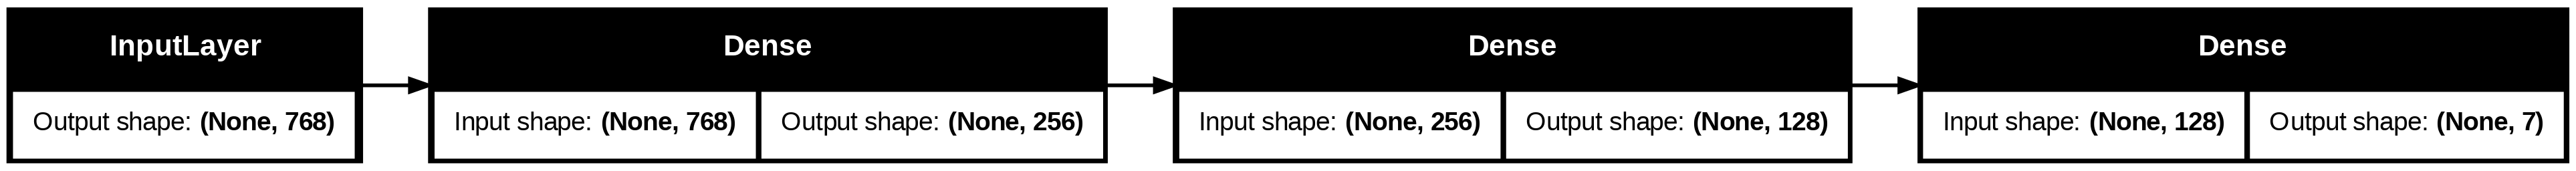

In [ ]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

#### Implement overfitting prevention measures and train model

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor="val_loss",  # Monitor validation loss
    patience=5,          # Stop training if val_loss does not improve for 5 epochs
    restore_best_weights=True  # Restore the best model weights
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",   # Reduce learning rate when val_loss stops improving
    factor=0.5,           # Reduce LR by half
    patience=3,           # Wait 3 epochs before reducing LR
    min_lr=1e-6           # Set a minimum learning rate
)

# Train the model with callbacks
history = model.fit(
    x=X_train_scaled,
    y=y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_scaled, y_test),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6782 - loss: 0.9462 - val_accuracy: 0.8981 - val_loss: 0.2938 - learning_rate: 0.0010
Epoch 2/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8398 - loss: 0.4653 - val_accuracy: 0.9130 - val_loss: 0.2691 - learning_rate: 0.0010
Epoch 3/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8853 - loss: 0.3506 - val_accuracy: 0.9259 - val_loss: 0.2689 - learning_rate: 0.0010
Epoch 4/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9095 - loss: 0.3028 - val_accuracy: 0.9241 - val_loss: 0.2652 - learning_rate: 0.0010
Epoch 5/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9464 - loss: 0.2078 - val_accuracy: 0.9389 - val_loss: 0.2610 - learning_rate: 0.0010
Epoch 6/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9495 - loss: 0.1897 - val_accuracy: 0.9426 - val_loss: 0.3021 - learning_rate: 0.0010
Epoch 7/100
232/232 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9503 - loss: 0

In [ ]:
    # Add per-epoch accuracy comparison
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    print("\nAccuracy by Epoch:")
    print("-" * 50)
    print(f"{'Epoch':<10} {'Training Acc':<15} {'Validation Acc':<15} {'Difference':<15}")
    print("-" * 50)
    for i in range(len(train_acc)):
        diff = val_acc[i] - train_acc[i]
        print(f"{i+1:<10} {train_acc[i]:.4f}{'':10} {val_acc[i]:.4f}{'':10} {diff:.4f} ({'Higher' if diff > 0 else 'Lower'})")


Accuracy by Epoch:
--------------------------------------------------
Epoch      Training Acc    Validation Acc  Difference     
--------------------------------------------------
1          0.7643           0.8981           0.1338 (Higher)
2          0.8476           0.9130           0.0654 (Higher)
3          0.8934           0.9259           0.0325 (Higher)
4          0.9127           0.9241           0.0114 (Higher)
5          0.9376           0.9389           0.0013 (Higher)
6          0.9501           0.9426           -0.0075 (Lower)
7          0.9520           0.9315           -0.0205 (Lower)
8          0.9724           0.9352           -0.0372 (Lower)
9          0.9926           0.9481           -0.0444 (Lower)
10         0.9959           0.9500           -0.0459 (Lower)


#### Evaluate performance

In [ ]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8505 - loss: 0.5671
Test Accuracy: 0.9389


#### Plot loss and accuracy

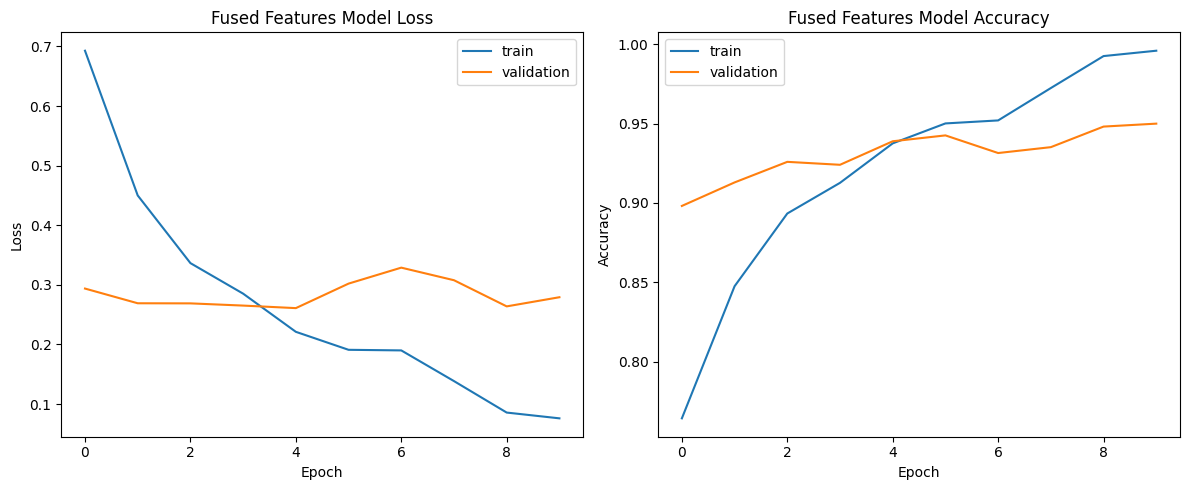

In [ ]:
# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Fused Features Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Fused Features Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()